# Trophic model for gut
## Consumer-Resource model (CRM) with Trophic levels
The human gut microal community is complex because of 3 reason: (1) many microbial species (~570); (2) many metabolites involoved (~244); and (3) many microbe-metabolite interactions/links (>4400). Of all types of microbe-metabolite interactions/links, the cross-feeding makes the system more complicated to interpret. Previously, a literature-curated interspecies network of the human gut microbiota, called [NJS16](https://www.nature.com/articles/ncomms15393) is reported. This is an extensive data resource composed of ∼570 microbial species and 3 human cell types metabolically interacting through >4,400 small-molecule transport and macromolecule degradation events.

Here, we devoted to build a Consumer-Resource model (CRM) with trophic levels posted in the paper "[a evidence for a multi-level trophic organization of the human gut microbiome](https://www.biorxiv.org/content/10.1101/603365v1.full-text)". The model is devoted to study the complex microbe-metabolite network in human guts.

In concise, in the mode, a trophic level is considered as one round of carbon processing and is composed of two process: resource allocation to microbes and the following resource/byproduct generation by microbes. The simulation is stopped after several trophic levels because the residence time of resource in the human gut is assumed to be finite.

Previously, the code for the model is written in Matlab. Here a Python version of the model is proposed, providing further convenience for Machine Learning model to learn uptake rates and byproduct generation rates of all microbial species to different metabolites.

In [246]:
########### Self-customized setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import math
from numba import jit, float64

#%% Plot Tong's default setting
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 3

In [7]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("Thai_data.pickle","rb")
thai_metagenome_ID, thai_metagenome, thai_metabolome_ID, thai_metabolome = pickle.load(pickle_in)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.3082972161368787
            Iterations: 14
            Function evaluations: 310
            Gradient evaluations: 14
     fun: 3.3082972161368787
     jac: array([ 0.00000000e+00, -6.15325570e-03, -2.90572643e-05,  2.35739350e-03,
        8.16664100e-03,  1.50786638e-02,  1.46860778e-02, -4.07725573e-04,
        1.19361281e-03,  1.25773847e-02, -2.30303407e-03, -2.99483538e-04,
        2.42887139e-02,  5.35169244e-02, -1.20905936e-02,  8.37150216e-03,
        9.80427861e-02,  2.01314688e-04,  4.41354513e-03,  1.83877051e-02])
 message: 'Optimization terminated successfully.'
    nfev: 310
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([5.00000000e-02, 2.82396174e-02, 1.49672925e+00, 9.00404585e-01,
       2.66745755e-02, 1.52703370e-16, 2.49504760e-17, 4.09981488e-02,
       1.58968702e-02, 0.00000000e+00, 1.44357890e-01, 1.43499947e+00,
       2.88696654e-17, 1.82546248

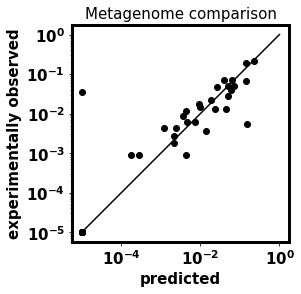

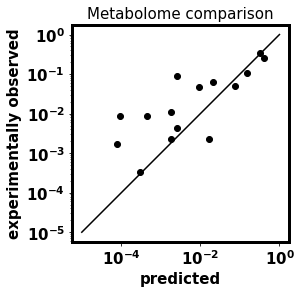

In [247]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID = 2244  # MAX_ID is the maximum of ID labels.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net.iloc[:,2]==2) | (net.iloc[:,2]==5))[0]
    row = net.iloc[valid_index,0]
    col = net.iloc[valid_index,1]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID,MAX_ID)).toarray()#.todense()

    valid_index = np.where((net.iloc[:,2]==3) | (net.iloc[:,2]==5))[0]
    row = net.iloc[valid_index,0]
    col = net.iloc[valid_index,1]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID,MAX_ID)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID)
    return [m2b, b2m]
'''
def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    m2m_layer = np.zeros((MAX_ID, MAX_ID, numLevels_max));  
    m2b_total = np.zeros((MAX_ID, MAX_ID));  
    
    s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID, MAX_ID);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]
'''
i_nonzero_microbes = net['microbes_ID'].unique()
i_nonzero_metabolites = net['metabolites_ID'].unique()

def array_mult(i_row_a, i_col_a, i_row_b, i_col_b, a, b):
    final_array_temp = np.dot(a[np.ix_(i_row_a, i_col_a)], b[np.ix_(i_row_b, i_col_b)])
    final_array = np.zeros((MAX_ID, MAX_ID))
    final_array[np.ix_(i_row_a, i_col_b)] = final_array_temp
    return final_array

def m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID, MAX_ID, numLevels_max));  
    m2b_total = np.zeros((MAX_ID, MAX_ID));  

    s_step = array_mult(i_nonzero_metabolites, i_nonzero_microbes, i_nonzero_microbes, i_nonzero_metabolites, b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID, MAX_ID);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID)

    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        s_step_ii = array_mult(i_nonzero_metabolites, i_nonzero_metabolites, i_nonzero_metabolites, i_nonzero_metabolites, s_step_ii, s_step);
    m2m_total = m2b_total;
    m2b_total = array_mult(i_nonzero_microbes, i_nonzero_metabolites, i_nonzero_metabolites, i_nonzero_metabolites, (1 - f_mul) * m2b.T, m2b_total); # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID, numLevels_max));
    
    x_full = np.zeros((MAX_ID,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID,))
metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))

## Find the number of unique microbia and metabolites in the Chia network

In [30]:
uniqueChiaBactIDs = np.sort(net['microbes_ID'].unique())
uniqueChiaMetIDs = np.sort(net['metabolites_ID'].unique())
print(uniqueChiaBactIDs.shape[0], uniqueChiaMetIDs.shape[0])

544 221


## Find the number of unique microbia and metabolites in the Thai data

In [35]:
print(thai_metagenome_ID.shape[0], thai_metabolome_ID.shape[0])
print(thai_metagenome_ID.shape[0]*thai_metabolome_ID.shape[0])

72 81
5832


[0.         0.         0.         0.2030303  0.09090909 0.
 0.         0.         0.         0.         5.98020787 0.
 0.         0.40854978 0.         0.         0.         0.
 0.         0.         0.         0.         0.91525476 0.
 0.         0.         0.         0.         0.         0.4789272
 0.1        0.         0.         0.         0.         0.1
 0.1        0.         0.         0.         0.         6.28751306
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         4.35636227 0.16364943 0.24604978
 0.         0.03448276 6.44104842 0.         0.17938312 0.
 0.         0.12539185 0.         0.10114943 0.         0.03448276
 0.         0.19698276 0.        ]
Consumption connectance is:  0.032578875171467764
Production connectance is:  0.030349794238683128


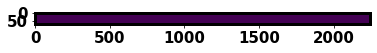

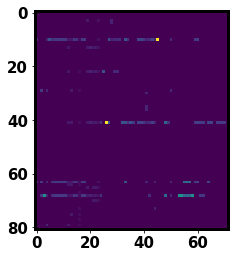

In [58]:
b_real = np.zeros((MAX_ID,))
b_real[thai_metagenome_ID] = 1
[m2b, b2m] = Ain_out(b_real, net)

plt.figure()
plt.imshow(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)])

#print(np.sum(m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)], 0))
#print(np.sum(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)], 0))
#print(np.sum(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)], 1))

print('Consumption connectance is: ',np.sum(m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0) / (thai_metagenome_ID.shape[0]*thai_metabolome_ID.shape[0]))
print('Production connectance is: ',np.sum(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0) / (thai_metagenome_ID.shape[0]*thai_metabolome_ID.shape[0]))


In [59]:
np.sum(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)], 1).shape

(81,)

In [248]:
corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
for pa in range(41):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID,))
    metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.43152099376378306, 0.00859394527538631)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.6145152231366302, 0.006656010659883466)
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9112067409061099, 2.676585526059427e-12)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.4113792818925748, 0.1276505214190439)
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the cor

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.7507381573067047, 3.705869637806499e-08)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.7481810481404969, 0.00022961977934424403)
21
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.7417394368724527, 3.425172140833967e-07)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.3091425229951885, 0.21193000537974097)
22
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the

KeyboardInterrupt: 

In [4]:
np.mean(corr_list[:,1])

NameError: name 'corr_list' is not defined

## Compute an average diet and stick to the average diet

In [62]:
average_diet = np.mean(diet_list, 0).copy()

In [178]:
#%%heat
corr_list_aveDiet = np.zeros((41,2))
for pa in range(41):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID,));
    x_full[i_intake] = average_diet.copy();
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID,))
    metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.42036613797943234, 0.010689786637539523)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.62386532243047, 0.005659898402854842)
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.7126071038089303, 9.963251587243866e-06)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.484135857802976, 0.06744597430576534)
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the corr

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.734437993958225, 1.0265883909519364e-07)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.7883446066430754, 6.0849875972201344e-05)
21
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.5967066097312398, 0.000154665141161594)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.2784663075193508, 0.26317017701445533)
22
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.4440625130557008, 0.010895447903684055)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.6548250043004457, 0.0023455075508009293)


In [ ]:
plt.figure()
plt.hist(corr_list_aveDiet[:,1]);
print(np.mean(corr_list_aveDiet[:,1]))

In [180]:
print(np.mean(corr_list_aveDiet[:,0]))

0.5205970094280451


Consumption connectance is:  0.032578875171467764
Production connectance is:  0.030349794238683128


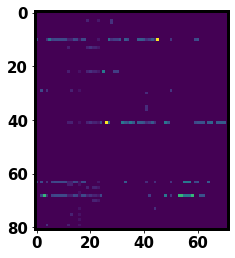

In [181]:
b_real = np.zeros((MAX_ID,))
b_real[thai_metagenome_ID] = 1
[m2b, b2m] = Ain_out(b_real, net)

plt.figure()
plt.imshow(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)])

#print(np.sum(m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)], 0))
#print(np.sum(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)], 0))
#print(np.sum(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)], 1))

print('Consumption connectance is: ', np.sum(m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0) / (thai_metagenome_ID.shape[0]*thai_metabolome_ID.shape[0]))
print('Production connectance is: ', np.sum(b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0) / (thai_metagenome_ID.shape[0]*thai_metabolome_ID.shape[0]))


In [103]:
m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
net_ori = net.copy()

In [157]:
print(len(net_ori), len(net_added_consumption), len(net_added_production))

4248 190 177


In [159]:
net = pd.concat([net_ori, net_added_consumption, net_added_production])

## Gradient descent over adding links

In [249]:
m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
    ######## Convert x to net structure:
    thres = 1e-10
    x = x - x_ori
    m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a.values), net_ori.columns[1]:list(b.values), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a.values), net_ori.columns[1]:list(b.values), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((4,2))
    for pa in range(4):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID,));
        x_full[i_intake] = average_diet.copy();
        ba_pred = np.dot(m2b_total, x_full)

        met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID,))
        metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''  
        
    x_full = np.zeros((MAX_ID,));
    x_full[i_intake] = average_diet.copy();
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    pred_error1 = np.mean(corr_list_aveDiet[:,0])
    pred_error2 = np.mean(corr_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    hyper_reg = 0.001
    pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    print(pred_error, pred_error3)
    
    return pred_error

fun = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
x0 = x_ori.copy()
bnds = ((0, 100), ) * max_links * 2
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

0.6624662145232207 0.0
0.6624662145232207 0.0
0.6624662145381219 1.4901161193847656e-08
0.6624662145381219 1.4901161193847656e-08
0.6624662145381219 1.4901161193847656e-08


KeyboardInterrupt: 

## Monte Carlo over adding links (using the average diet)

In [250]:
import random
m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
    ######## Convert x to net structure:
    thres = 0.1
    x = x - x_ori
    m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a.values), net_ori.columns[1]:list(b.values), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a.values), net_ori.columns[1]:list(b.values), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((41,2))
    log_list_aveDiet = np.zeros((41,2))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID,));
        x_full[i_intake] = average_diet.copy();
        ba_pred = np.dot(m2b_total, x_full)

        met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID,))
        metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''  
        
    x_full = np.zeros((MAX_ID,));
    x_full[i_intake] = average_diet.copy();
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    #pred_error1 = np.mean(corr_list_aveDiet[:,0])
    #pred_error2 = np.mean(corr_list_aveDiet[:,1])
    #pred_error3 = np.sum(np.abs(x))
    #hyper_reg = 0.01
    #pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    hyper_reg = 0.01
    pred_error = pred_error1 + pred_error2 + hyper_reg * pred_error3
    print(pred_error, pred_error3)
    
    return pred_error

fun = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
x = x_ori.copy()
error_before = fun(x)
for i in range(100):
    i_x = random.randint(0,max_links*2)
    x[i_x] = 1
    error_after = fun(x)
    if np.random.uniform(0,1,1)[0] > np.exp(1000*(error_before - error_after)):  ## not accepted
        x[i_x] = 0
        print('not accepted, error is', error_before)
    else:  ## accepted   
        error_before = error_after
        print('accepted, error is', error_before)
    #print(error_after / error_before)

1.6665375599602643 0
1.6722135064658097 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6730344225337872 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6782399216523276 1
not accepted, error is 1.6665375599602643
1.6789812774891735 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6765498263458898 1
not accepted, error is 1.6665375599602643
1.678826792709223 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, error is 1.6665375599602643
1.6765375599602643 1
not accepted, 

In [244]:
#pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]

np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-5) - np.log10(b_real[b_real>0]+1e-5)))
np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))

0.7073242655976671

## Monte Carlo over adding links (using the optimized diet)

In [ ]:
import random
m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
    
    ######## Convert x to net structure:
    thres = 0.1
    x = x - x_ori
    m2b_added = x[:max_links].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a.values), net_ori.columns[1]:list(b.values), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((thai_metabolome_ID.shape[0], thai_metagenome_ID.shape[0]))
    a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a.values), net_ori.columns[1]:list(b.values), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list = np.zeros((4,2))
    for pa in range(4):
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## Assign diet
        x_diet0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun = lambda x_diet: pred_error(x_diet, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x_diet0)
        res = minimize(fun, x_diet0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID,))
        metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        
    x_full = np.zeros((MAX_ID,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    pred_error1 = np.mean(corr_list[:,0])
    pred_error2 = np.mean(corr_list[:,1])
    pred_error3 = np.sum(np.abs(x))
    hyper_reg = 0.01
    pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    print(pred_error, pred_error3)
    
    return pred_error

fun2 = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = thai_metabolome_ID.shape[0]*thai_metagenome_ID.shape[0]
x = x_ori.copy()
error_before = fun2(x)
for i in range(100):
    i_x = random.randint(0,max_links*2)
    x[i_x] = 1
    error_after = fun2(x)
    if np.random.uniform(0,1,1)[0] > np.exp(1000*(error_before - error_after)):  ## not accepted
        x[i_x] = 0
        print('not accepted, error is', error_after)
    else:  ## accepted   
        error_before = error_after
        print('accepted, error is', error_after)
    #print(error_after / error_before)